## Load data

In [347]:
import pandas as pd

#### Most downloaded

In [348]:
data_loaded = pd.read_excel('JPSM top-downloaded-cited.xlsx', sheet_name='MOST DOWNLOADED')
data_loaded.head(2)

,issn,journal,pii,doi,title,authors,volume,volume title,issue,supplement,article type,online date,cover date,full article views/ downloads
0,0885-3924,Journal of Pain and Symptom Management,S088539241000391X,10.1016/j.jpainsymman.2010.01.021,Symptoms in the Month Before Death for Stage 5...,"Murtagh, F.; Addington-Hall, J.; Edmonds, P.; ...",40,NaN,3,NaN,Full-length article,2010-07-01,2010-09-01,145346
1,0885-3924,Journal of Pain and Symptom Management,S0885392411000145,10.1016/j.jpainsymman.2010.08.016,"Studies Comparing Numerical Rating Scales, Ver...","Hjermstad, M.; Fayers, P.; Haugen, D.; Caracen...",41,NaN,6,NaN,Review article,2011-05-27,2011-06-01,143923


#### Most cited

In [349]:
data_cited = pd.read_excel('JPSM top-downloaded-cited.xlsx', sheet_name='MOST CITED')
data_cited.head(2)

,Source title,Year,Title,Authors,Volume,Issue,Art. No.,Page start,Page end,Page count,Lifetime Citations,DOI,Link,Document Type,Publication Stage,Open Access,Source,EID
0,Journal of Pain and Symptom Management,2011,"Studies comparing numerical rating scales, ver...",Hjermstad M.J.; Fayers P.M.; Haugen D.F.; Cara...,41,6,NaN,1073,1093,20.0,1994,10.1016/j.jpainsymman.2010.08.016,https://www.scopus.com/inward/record.uri?eid=2...,Review,Final,All Open Access; Green Open Access,Scopus,2-s2.0-79957652902
1,Journal of Pain and Symptom Management,2016,Update on Prevalence of Pain in Patients with ...,Van Den Beuken-Van Everdingen M.H.J.; Hochsten...,51,6,NaN,1070,1090000000000,NaN,1226,10.1016/j.jpainsymman.2015.12.340,https://www.scopus.com/inward/record.uri?eid=2...,Review,Final,NaN,Scopus,2-s2.0-84973102519


## Data extraction methods

In [350]:
import re
import fitz  #PyMuPDF

def extract_doi_and_all_text(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        all_text = ""
        for page in doc:
            all_text += page.get_text("text")
        doc.close()
        doi_match = re.search(r'\b10\.\d{4,9}/[-._;()/:A-Z0-9]+\b', all_text, re.IGNORECASE)
        doi = doi_match.group(0).lower().strip() if doi_match else None
        return doi, all_text
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
        return None, None

In [351]:
def extract_full_paper(text, start_keyword, end_keyword):
    start_index = text.find(start_keyword)
    if start_index == -1:
        return ""
    content_start_index = start_index + len(start_keyword)
    end_index = text.find(end_keyword, content_start_index)
    if end_index == -1:
        return text[content_start_index:] 
    return text[content_start_index:end_index]

In [352]:
def extract_abstract(text, start_keyword='Abstract', end_keyword='Key Words'):
    start_index = text.find(start_keyword)
    if start_index == -1:
        return ""
    content_start_index = start_index + len(start_keyword)
    end_index = text.find(end_keyword, content_start_index)
    if end_index == -1:
        return text[content_start_index:] 
    return text[content_start_index:end_index]

In [353]:
def extract_keywords(text, keyword="Key Words"):
    lines = text.split('\n')
    for i, line in enumerate(lines):
        if keyword in line:
            if i + 1 < len(lines):
                next_line = lines[i + 1].strip()
                return next_line
            else:
                return ""
    return ""

In [354]:
def cleaning(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    return text.strip()

#### Extract full text

In [355]:
# this method may take 2-5 minutes to run
import os
import pandas as pd

pdf_folder = "paper_cited"
df_meta = data_cited.copy()
output_csv = "output_data_cited.csv"

# pdf_folder = "paper_loaded"
# df_meta = data_loaded.copy()
# output_csv = "output_data_downloaded.csv"

df_meta['doi'] = df_meta['DOI'].str.lower().str.strip()
df_meta['filename'] = ""
df_meta['abstract'] = ""
df_meta['keywords'] = ""
df_meta['full_text'] = ""

for filename in os.listdir(pdf_folder):
    if not filename.lower().endswith(".pdf"):
        continue
    pdf_path = os.path.join(pdf_folder, filename)
    doi, text = extract_doi_and_all_text(pdf_path)
    full_text = extract_full_paper(text, 'Introduction', 'References')
    abst_ = extract_abstract(text, 'Abstract', 'J Pain Symptom Manage')
    keywords = extract_keywords(text, keyword="Key Words")
    if doi and text:
        doi = doi.strip().lower()
        match_index = df_meta[df_meta['doi'] == doi].index
        if not match_index.empty:
            df_meta.loc[match_index[0], 'filename'] = filename
            df_meta.loc[match_index[0], 'abstract'] = cleaning(abst_)
            df_meta.loc[match_index[0], 'keywords'] = keywords
            df_meta.loc[match_index[0], 'full_text'] = cleaning(full_text)
        else:
            print(f"Some info not found in CSV: {doi}, {filename}")
    else:
        print(f"Could not extract DOI from: {filename}")

try:
    df_meta.to_csv(output_csv, index=False)
    print(f"Saved data in {output_csv}")
except Exception as e:
    print(f"Error saving CSV: {e}")

Saved data in output_data_cited.csv


In [356]:
df_meta.head(3)

,Source title,Year,Title,Authors,Volume,Issue,Art. No.,Page start,Page end,Page count,...,Document Type,Publication Stage,Open Access,Source,EID,doi,filename,abstract,keywords,full_text
0,Journal of Pain and Symptom Management,2011,"Studies comparing numerical rating scales, ver...",Hjermstad M.J.; Fayers P.M.; Haugen D.F.; Cara...,41,6,NaN,1073,1093,20.0,...,Review,Final,All Open Access; Green Open Access,Scopus,2-s2.0-79957652902,10.1016/j.jpainsymman.2010.08.016,PIIS0885392411000145.pdf,Context. The use of unidimensional pain scales...,"Pain assessment, pain intensity, Numerical Rat...",There is an extensive literature regarding the...
1,Journal of Pain and Symptom Management,2016,Update on Prevalence of Pain in Patients with ...,Van Den Beuken-Van Everdingen M.H.J.; Hochsten...,51,6,NaN,1070,1090000000000,NaN,...,Review,Final,NaN,Scopus,2-s2.0-84973102519,10.1016/j.jpainsymman.2015.12.340,PIIS0885392416300483.pdf,Context. Cancer pain has a severe impact on qu...,"Cancer pain, prevalence, systematic review, me...",At the beginning of the global year against ca...
2,Journal of Pain and Symptom Management,2017,Defining Advance Care Planning for Adults: A C...,Sudore R.L.; Lum H.D.; You J.J.; Hanson L.C.; ...,53,5,NaN,821,8320,NaN,...,Article,Final,All Open Access; Green Open Access,Scopus,2-s2.0-85018681302,10.1016/j.jpainsymman.2016.12.331,PIIS0885392416312325.pdf,Context. Despite increasing interest in advanc...,"Advance care planning, consensus, Delphi techn...",Initiatives to improve advance care planning (...


## Data preprocessing

In [357]:
import nltk
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel


In [358]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/masudur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/masudur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/masudur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [359]:
#!python -m spacy download en_core_web_sm
import spacy
import string

nlp = spacy.load("en_core_web_sm")

In [360]:
tokenized_text = df_meta['full_text'].apply(word_tokenize)
#tokenized_text
total = tokenized_text.sum()
len(total)

1174093

In [361]:
to_remove = set([
    'age', 'also', 'article', 'abstract', 'abstracts' \
    'background', 'base', 'better', \
    'care', 'common', 'compare', 'conclusion', 'control', 'cope', 'correlate', \
    'data', 'datum', 'day', 'different', 'disorder', 'early', 'examine', 'fact', 'factor', 'female', 'four', \
    'gain', 'gender', 'group', 'great', 'health', 'high', 'hospice', \
    'identify', 'include', 'increase', 'introduction', 'issue', 'item', \
    'last', 'late', 'less', 'level', 'life', 'likely', 'low', 'lower', \
    'make', 'male', 'man', 'material', 'may', 'measure', 'method', 'methods', 'month', 'need', \
    'nine', 'one', 'Original', 'outcome', 'patient', 'patients', 'program', 'provide', \
    'rate', 'receive', 'related', 'relate', 'report', 'research', 'result', 'results', 'review', 'role', 'rslp', \
    'score', 'scores', 'see', 'self', 'service', 'set', 'sex', 'seven', 'significant', 'similar', 'six', 'study', 'studies', \
    'ten', 'tens', 'test', 'three', 'time', 'treatment', 'trial', 'two', 'tive', 'use', 'vol', 'well', 'woman', 'year'
    ])
#to_removed

In [362]:
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']

In [363]:
# this function may take 3-5 minutes to run
def preprocessing(doc):
    doc_clean = doc.lower().translate(str.maketrans('', '', string.punctuation))
    spacy_doc = nlp(doc_clean)
    tokens = []
    for token in spacy_doc:
        if (
            token.is_alpha and
            token not in to_remove and
            token.pos_ in allowed_postags and
            token.lemma_ not in stop_words and
            len(token.lemma_) >= 3
        ):
            tokens.append(token.lemma_.lower())
    
    return tokens

In [364]:
df_meta['fulltext_tokens'] = df_meta['full_text'].apply(preprocessing)

In [365]:
df_meta.head(3)

,Source title,Year,Title,Authors,Volume,Issue,Art. No.,Page start,Page end,Page count,...,Publication Stage,Open Access,Source,EID,doi,filename,abstract,keywords,full_text,fulltext_tokens
0,Journal of Pain and Symptom Management,2011,"Studies comparing numerical rating scales, ver...",Hjermstad M.J.; Fayers P.M.; Haugen D.F.; Cara...,41,6,NaN,1073,1093,20.0,...,Final,All Open Access; Green Open Access,Scopus,2-s2.0-79957652902,10.1016/j.jpainsymman.2010.08.016,PIIS0885392411000145.pdf,Context. The use of unidimensional pain scales...,"Pain assessment, pain intensity, Numerical Rat...",There is an extensive literature regarding the...,"[extensive, literature, regard, use, numerical..."
1,Journal of Pain and Symptom Management,2016,Update on Prevalence of Pain in Patients with ...,Van Den Beuken-Van Everdingen M.H.J.; Hochsten...,51,6,NaN,1070,1090000000000,NaN,...,Final,NaN,Scopus,2-s2.0-84973102519,10.1016/j.jpainsymman.2015.12.340,PIIS0885392416300483.pdf,Context. Cancer pain has a severe impact on qu...,"Cancer pain, prevalence, systematic review, me...",At the beginning of the global year against ca...,"[beginning, global, year, cancer, internationa..."
2,Journal of Pain and Symptom Management,2017,Defining Advance Care Planning for Adults: A C...,Sudore R.L.; Lum H.D.; You J.J.; Hanson L.C.; ...,53,5,NaN,821,8320,NaN,...,Final,All Open Access; Green Open Access,Scopus,2-s2.0-85018681302,10.1016/j.jpainsymman.2016.12.331,PIIS0885392416312325.pdf,Context. Despite increasing interest in advanc...,"Advance care planning, consensus, Delphi techn...",Initiatives to improve advance care planning (...,"[initiative, improve, advance, care, planning,..."


#### Divide by periods

In [366]:
# run for most cited data
periods = {
    "2009–2016": df_meta[(df_meta['Year'] >= 2009) & (df_meta['Year'] <= 2016)],
    "2017–2024": df_meta[(df_meta['Year'] >= 2017) & (df_meta['Year'] <= 2024)]
}
#periods

In [367]:
periods['2009–2016'].head()

,Source title,Year,Title,Authors,Volume,Issue,Art. No.,Page start,Page end,Page count,...,Publication Stage,Open Access,Source,EID,doi,filename,abstract,keywords,full_text,fulltext_tokens
0,Journal of Pain and Symptom Management,2011,"Studies comparing numerical rating scales, ver...",Hjermstad M.J.; Fayers P.M.; Haugen D.F.; Cara...,41,6,NaN,1073,1093,20.0,...,Final,All Open Access; Green Open Access,Scopus,2-s2.0-79957652902,10.1016/j.jpainsymman.2010.08.016,PIIS0885392411000145.pdf,Context. The use of unidimensional pain scales...,"Pain assessment, pain intensity, Numerical Rat...",There is an extensive literature regarding the...,"[extensive, literature, regard, use, numerical..."
1,Journal of Pain and Symptom Management,2016,Update on Prevalence of Pain in Patients with ...,Van Den Beuken-Van Everdingen M.H.J.; Hochsten...,51,6,NaN,1070,1090000000000,NaN,...,Final,NaN,Scopus,2-s2.0-84973102519,10.1016/j.jpainsymman.2015.12.340,PIIS0885392416300483.pdf,Context. Cancer pain has a severe impact on qu...,"Cancer pain, prevalence, systematic review, me...",At the beginning of the global year against ca...,"[beginning, global, year, cancer, internationa..."
5,Journal of Pain and Symptom Management,2010,"Multicenter, Double-Blind, Randomized, Placebo...",Johnson J.R.; Burnell-Nugent M.; Lossignol D.;...,39,2,NaN,167,179,12.0,...,Final,All Open Access; Bronze Open Access,Scopus,2-s2.0-75949093107,10.1016/j.jpainsymman.2009.06.008,PIIS0885392409007878.pdf,This study compared the efﬁcacy of a tetrahydr...,"Cancer, pain, tetrahydrocannabinol, cannabidio...","Cancer pain is a common problem, and 70%e90% o...","[cancer, pain, common, problem, patient, advan..."
8,Journal of Pain and Symptom Management,2010,Estimate of current hospice and palliative med...,Lupu D.,40,6,NaN,899,911,12.0,...,Final,All Open Access; Bronze Open Access,Scopus,2-s2.0-78649933024,10.1016/j.jpainsymman.2010.07.004,PIIS0885392410006020.pdf,Context. In the context of the establishment o...,"Physician workforce, hospice and palliative me...",The National Priorities Partnership has highli...,"[national, priority, partnership, highlight, p..."
9,Journal of Pain and Symptom Management,2013,Mapping levels of palliative care development:...,Lynch T.; Connor S.; Clark D.,45,6,NaN,1094,1106,12.0,...,Final,All Open Access; Bronze Open Access,Scopus,2-s2.0-84878833986,10.1016/j.jpainsymman.2012.05.011,PIIS088539241200334X.pdf,Our purpose is to categorize palliative care d...,"Palliative care, hospice, map, global development",Interest in the comparative analysis of pallia...,"[interest, comparative, analysis, pallia, tive..."


In [368]:
periods['2009–2016']['fulltext_tokens']

0      [extensive, literature, regard, use, numerical...
1      [beginning, global, year, cancer, internationa...
5      [cancer, pain, common, problem, patient, advan...
8      [national, priority, partnership, highlight, p...
9      [interest, comparative, analysis, pallia, tive...
                             ...                        
195    [cancer, treatment, aim, sur, vival, also, imp...
196    [fatigue, common, report, prevalence, cancerre...
197    [health, care, support, family, caregiver, pat...
198    [constipation, common, problem, palliative, ca...
199    [prevalence, chronic, pain, breast, cancer, su...
Name: fulltext_tokens, Length: 156, dtype: object

### Word cloud

In [369]:
#!pip install wordcloud

In [370]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

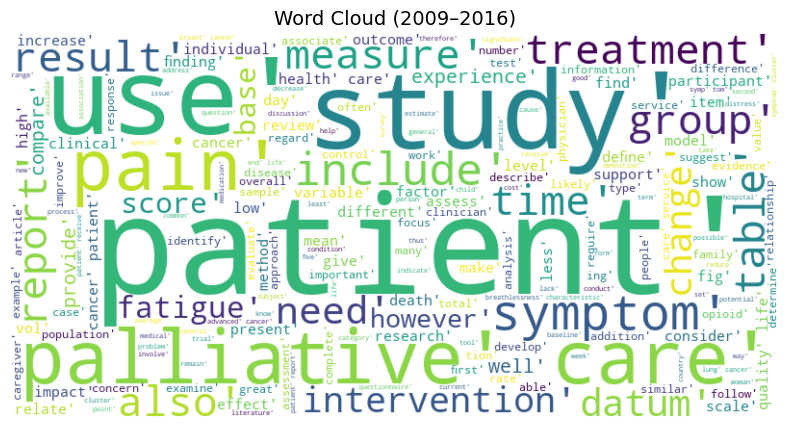

Saved: wordcloud_2009_2016.png


<Figure size 640x480 with 0 Axes>

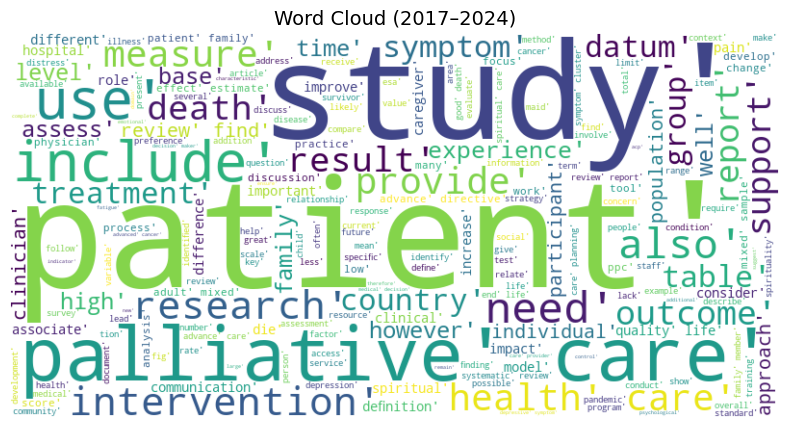

Saved: wordcloud_2017_2024.png


<Figure size 640x480 with 0 Axes>

In [371]:
for label, period in periods.items():
    text = ' '.join(period['fulltext_tokens'].dropna().astype(str))
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud ({label})', fontsize=14)
    plt.show()
    filename = f"wordcloud_{label.replace('–', '_')}.png"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    print(f"Saved: {filename}")

## LDA model

In [372]:
from gensim import corpora

In [373]:
# this function may take 3-5 minutes to run
from keybert import KeyBERT
kw_model = KeyBERT()

for label, period in periods.items():
    text_ = period['fulltext_tokens'].dropna()
    dictionary = corpora.Dictionary(text_)
    #dictionary.filter_extremes(no_below=5, no_above=0.5) 
    #no_below(int, optional): Keep tokens contained in at least no_below documents.
    #no_above(float, optional): Keep tokens contained in no more than no_above documents (fraction of total corpus size)

    corpus = [dictionary.doc2bow(text) for text in text_]

    #ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=20)
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=100, random_state=100)
    #ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
    #ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
    #ldamodel.save('model5.gensim')

    print(f'\n\nTop topics ({label})\n=============')    
    
    topics = ldamodel.show_topics(formatted=False)

    for i, words in topics:
        topic_words = ", ".join([w for w, _ in words])
        keywords = kw_model.extract_keywords(topic_words, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=1)
        print(f"Topic {i+1} '{keywords[0][0]}': {topic_words}")



Top topics (2009–2016)
Topic 1 'patient class': patient, class, visit, clinician, medication, study, fil, psych, burnout, latent
Topic 2 'pain patient': pain, patient, study, demoralization, treatment, level, placebo, day, thccbd, country
Topic 3 'patient palliative': care, patient, palliative, study, death, use, family, service, home, health
Topic 4 'palliative set': care, indicator, patient, quality, cognitive, study, cancer, palliative, set, domain
Topic 5 'opioid study': patient, care, opioid, study, palliative, use, dose, table, group, physician
Topic 6 'patient study': pain, patient, study, use, scale, score, report, point, cancer, chronic
Topic 7 'patient group': patient, group, study, intervention, week, score, effect, treatment, cancer, control
Topic 8 'cancer fatigue': symptom, patient, study, cancer, fatigue, score, use, cluster, distress, scale
Topic 9 'patient palliative': patient, palliative, sedation, care, death, life, existential, suffering, use, study
Topic 10 'brea

In [374]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')

Coherence Score: 0.4144578061199657


### Plot topics

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models
from gensim import corpora
from keybert import KeyBERT
import gensim
import os

kw_model = KeyBERT()
os.makedirs("lda_vis", exist_ok=True)

for label, period in periods.items():
    print(f"\nProcessing period: {label}")

    text_ = period['fulltext_tokens'].dropna()
    dictionary = corpora.Dictionary(text_)
    corpus = [dictionary.doc2bow(text) for text in text_]

    ldamodel = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        num_topics=10,
        id2word=dictionary,
        passes=100,
        random_state=100
    )

    topics = ldamodel.show_topics(formatted=False)

    vis_data = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
    vis_file = f"lda_vis/lda_vis_{label.replace('–', '_')}.html"
    pyLDAvis.save_html(vis_data, vis_file)
    print(f"Saved visualization: {vis_file}")


Processing period: 2009–2016
Saved visualization: lda_vis/lda_vis_2009_2016.html

Processing period: 2017–2024


## sklearn

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

for label, period in periods.items():
    print(f"\n\nTopics for period: {label}")
    print("=" * 40)
    docs = period['fulltext_tokens'].dropna().apply(lambda tokens: ' '.join(tokens))

    vectorizer = CountVectorizer(max_df=0.95, min_df=2)
    dtm = vectorizer.fit_transform(docs)

    lda = LatentDirichletAllocation(n_components=10, random_state=42)
    lda.fit(dtm)

    feature_names = vectorizer.get_feature_names_out()
    for index, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-10:]]
        print(f"Topic {index+1}: {', '.join(top_words)}")

## Key words stats

In [ ]:
from collections import Counter
import pandas as pd

def count_keywords(keywords):
    drop_comma = lambda x: [word.strip().lower() for word in x.split(',') if word.strip()]
    df_key_words = keywords.dropna().apply(drop_comma)
    word_counts = Counter([word for sublist in df_key_words for word in sublist])
    
    all_keywords = pd.DataFrame(word_counts.items(), columns=['key words', 'count'])
    all_keywords = all_keywords.sort_values(by='count', ascending=False).reset_index(drop=True)
    
    return all_keywords


In [ ]:
results = {}

for label, df_meta in periods.items():
    keywords_df = count_keywords(df_meta['keywords'])
    results[label] = keywords_df
    print(f"\nTop Keywords for {label}: ")
    print(keywords_df.head(15))